# Co-train

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from dashboard_helper import get_learner, inspect_runs, predict, get_transform_from_learner
from cotrain_helper import *

%load_ext autoreload
%autoreload 2

In [18]:
dataset = 'sharp'
seed = 3
output_dir = pathlib.Path(f'output_{dataset}_{seed}')
output_dir.mkdir(parents=True, exist_ok=True)

In [19]:
## The working directory should be in the branch of leaderboard3
dfs = {estimator: predict(dataset, seed, estimator)
       for estimator in ['CNN', 'LSTM']}

Select iloc 0 from 
                         start_time tags.mlflow.runName  \
82 2021-06-27 16:03:33.239000+00:00            LSTM_CNN   

               tags.mlflow.source.git.commit  
82  e13810ffddafdb818df7c4de68d9eafd67861e8c  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 1, 4, 4]         --
|    └─Conv3d: 2-1                       [-1, 64, 1, 128, 128]     7,808
|    └─BatchNorm3d: 2-2                  [-1, 64, 1, 128, 128]     128
|    └─ReLU: 2-3                         [-1, 64, 1, 128, 128]     --
|    └─MaxPool3d: 2-4                    [-1, 64, 1, 64, 64]       --
|    └─Conv3d: 2-5                       [-1, 64, 1, 64, 64]       102,464
|    └─BatchNorm3d: 2-6                  [-1, 64, 1, 64, 64]       128
|    └─ReLU: 2-7                         [-1, 64, 1, 64, 64]       --
|    └─MaxPool3d: 2-8                    [-1, 64, 1, 32, 32]       --
|    └─Conv3d: 2-9                       [-1, 64, 1, 32, 32]       36,928
|    └─BatchNorm3d: 2-10                 [-1, 64, 1, 32, 32]       128
|    └─ReLU: 2-11                        [-1, 64, 1, 32, 32]       --
|    └─MaxPool3d: 2-12                   [-1, 64, 1, 16, 16]       --


/home/zeyusun/work/flare-prediction-smarp/arnet/dataset.py:158: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


Select iloc 0 from 
                         start_time tags.mlflow.runName  \
82 2021-06-27 16:03:33.239000+00:00            LSTM_CNN   

               tags.mlflow.source.git.commit  
82  e13810ffddafdb818df7c4de68d9eafd67861e8c  


/home/zeyusun/work/flare-prediction-smarp/arnet/dataset.py:158: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

## Get data

In [20]:
df_train = get_split(dfs, 'train')
df_val = get_split(dfs, 'val')
df_test = get_split(dfs, 'test')

In [21]:
evaluate(df_val)

[0.03672316384180791, 0.06120527306967985]

In [22]:
evaluate(df_test)

[0.07598499061913697, 0.08911819887429644]

## Minimize cross-entropy loss

In [23]:
# Disable the orca response timeout.
import plotly.io._orca
import retrying
unwrapped = plotly.io._orca.request_image_with_retrying.__wrapped__
wrapped = retrying.retry(wait_random_min=1000)(unwrapped)
plotly.io._orca.request_image_with_retrying = wrapped

In [24]:
# import plotly
# import time
# plotly.io.orca.ensure_server()
# time.sleep(10)

In [25]:
%matplotlib inline

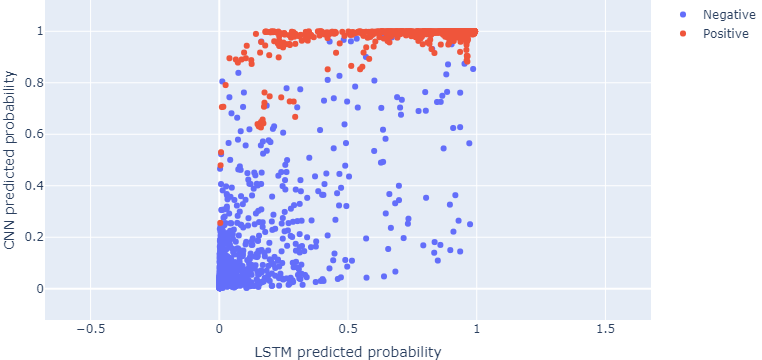

In [26]:
fig = plot_level_one(df_train)
fig.write_image(str(output_dir / 'data_train.png'))
fig

[0.07598499061913697, 0.08911819887429644, 0.07410881801125703]
0.9237180938021216


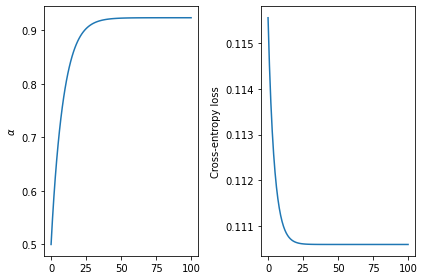

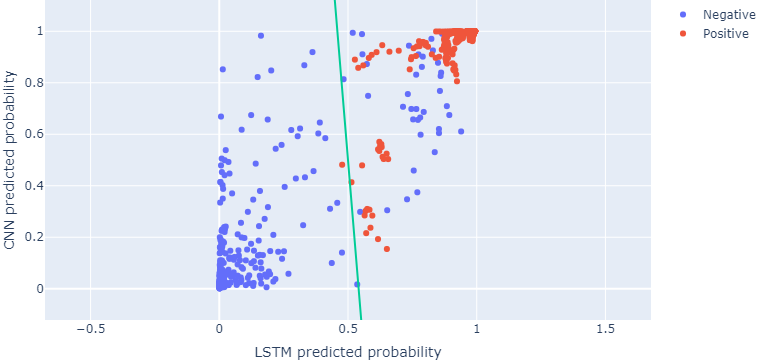

In [30]:
X_val = df_val[['LSTM prob', 'CNN prob']].to_numpy()
y_val = df_val['label'].to_numpy().astype(int)

ml = MetaLearner(step=2)
ml.fit(X_val, y_val)

print(evaluate(df_test, alpha=ml.alpha))
print(ml.alpha)

## Plot
alphas, funs = zip(*ml.out)

plt.figure()
plt.subplot(121); plt.plot(alphas); plt.ylabel(r'$\alpha$')
plt.subplot(122); plt.plot(funs); plt.ylabel('Cross-entropy loss')
plt.tight_layout()
plt.show()

fig = plot_level_one(df_val, alpha=ml.alpha)
fig.write_image(str(output_dir / 'data_val.png'))
fig

[0.07598499061913697, 0.08911819887429644, 0.08067542213883677]
0.38416117458942506


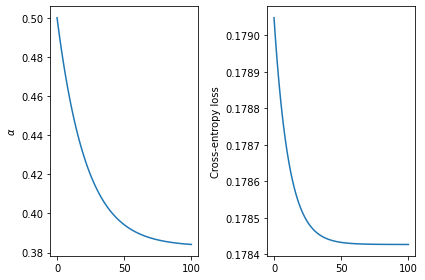

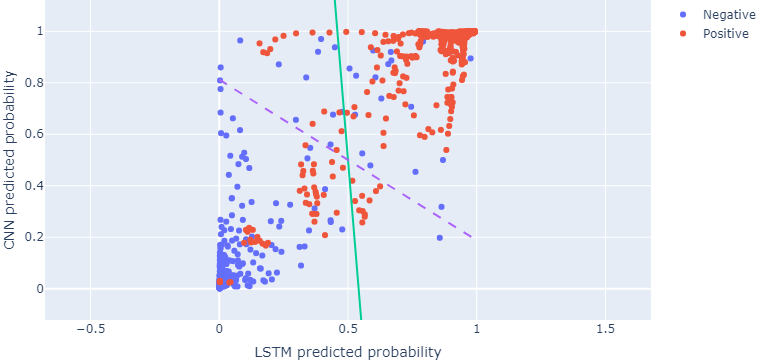

In [31]:
X_test = df_test[['LSTM prob', 'CNN prob']].to_numpy()
y_test = df_test['label'].to_numpy().astype(int)

ml_test = MetaLearner()
ml_test = ml_test.fit(X_test, y_test)

print(evaluate(df_test, alpha=ml_test.alpha))
print(ml_test.alpha)

## Plot
alphas, funs = zip(*ml_test.out)

plt.figure()
plt.subplot(121); plt.plot(alphas); plt.ylabel(r'$\alpha$')
plt.subplot(122); plt.plot(funs); plt.ylabel('Cross-entropy loss')
plt.tight_layout()
plt.show()

fig = plot_level_one(df_test, alpha=ml.alpha)
intercept = 0.5 / (1 - ml_test.alpha)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[intercept, 1-intercept],
        mode='lines',
        line=dict(
            dash='dash',
        ),
        showlegend=False,
        #name='Ensemble decision border'
    )
)
fig.write_image(str(output_dir / 'data_test.png'))
fig

## Minimizing 0-1 Loss

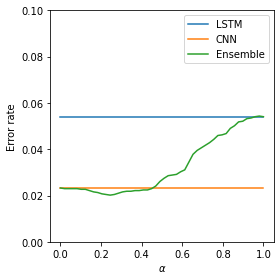

In [32]:
plot_alpha(df_train)
plt.savefig(output_dir / 'alpha_train.png')
plt.show()

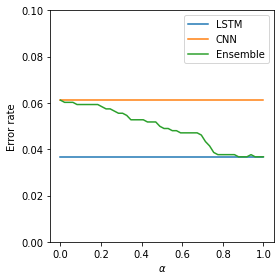

In [33]:
plot_alpha(df_val)
plt.savefig(output_dir / 'alpha_val.png')
plt.show()

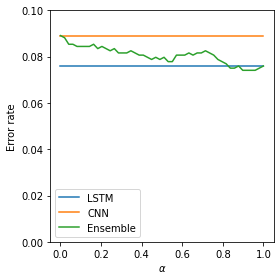

In [34]:
plot_alpha(df_test)
plt.savefig(output_dir / 'alpha_test.png')
plt.show()

## Visualize samples

1. Base learners
    * +, LSTM -, CNN +: Red, upper left
    * -, LSTM +, CNN -: Blue, lower right
2. Stacking: not possible
    * +, LSTM -, CNN -, ensemble +: 
    * -, LSTM +, CNN +, ensemble -:
3. Stacking:
    * +, LSTM -, CNN +, ensemble +: Red, upper left, upper right to the line
    * -, LSTM +, CNN -, ensemble -: Blue, lower right, lower left to the line

In [35]:
df_pos = df_test.loc[
    df_test['label'] &
    (df_test['LSTM prob'] < 0.5) &
    (df_test['CNN prob'] > 0.5)
]
df_pos['Ensemble prob'] = np.dot(
    df_pos[['LSTM prob', 'CNN prob']],
    [ml.alpha, 1 - ml.alpha]
)
df_neg = df_test.loc[
    ~df_test['label'] &
    (df_test['LSTM prob'] > 0.5) &
    (df_test['CNN prob'] < 0.5)
]
df_neg['Ensemble prob'] = np.dot(
    df_neg[['LSTM prob', 'CNN prob']],
    [ml.alpha, 1 - ml.alpha]
)

<ipython-input-35-66879b012154>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-66879b012154>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
from arnet.dataset import ActiveRegionDataModule
learner = get_learner(dataset, seed, 'CNN')
# hotfix
learner.cfg.DATA.DATABASE = '/home/zeyusun/work/flare-prediction-smarp/' + str(learner.cfg.DATA.DATABASE)
learner.cfg.DATA.AUXDATA = '/home/zeyusun/work/flare-prediction-smarp/' + str(learner.cfg.DATA.AUXDATA)
learner.cfg.DATA.TRANSFORMS = []
learner.cfg.DATA.FEATURES = ['MAGNETOGRAM', 'USFLUXL', 'MEANGBL', 'R_VALUE', 'AREA']
dm = ActiveRegionDataModule(learner.cfg)

Select iloc 0 from 
                         start_time tags.mlflow.runName  \
82 2021-06-27 16:03:33.239000+00:00            LSTM_CNN   

               tags.mlflow.source.git.commit  
82  e13810ffddafdb818df7c4de68d9eafd67861e8c  
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 1, 4, 4]         --
|    └─Conv3d: 2-1                       [-1, 64, 1, 128, 128]     7,808
|    └─BatchNorm3d: 2-2                  [-1, 64, 1, 128, 128]     128
|    └─ReLU: 2-3                         [-1, 64, 1, 128, 128]     --
|    └─MaxPool3d: 2-4                    [-1, 64, 1, 64, 64]       --
|    └─Conv3d: 2-5                       [-1, 64, 1, 64, 64]       102,464
|    └─BatchNorm3d: 2-6                  [-1, 64, 1, 64, 64]       128
|    └─ReLU: 2-7                         [-1, 64, 1, 64, 64]       --
|    └─MaxPool3d: 2-8                    [-1, 64, 1, 32, 32]       --
|    └─Conv3d: 2-9                       [-1, 64, 1,

/home/zeyusun/work/flare-prediction-smarp/arnet/dataset.py:158: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



In [38]:
dl_pos = dm.get_dataloader(df_pos)
dl_neg = dm.get_dataloader(df_neg)

## Look into the samples in a statistician's perspective

0


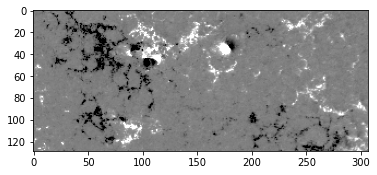

1


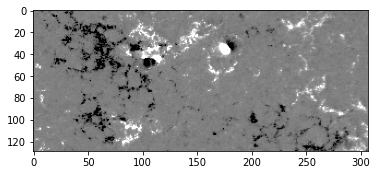

2


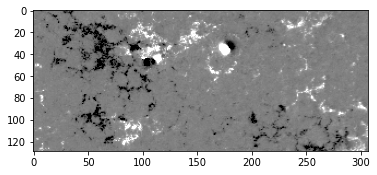

3


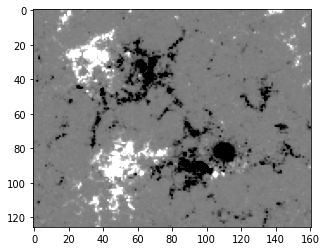

4


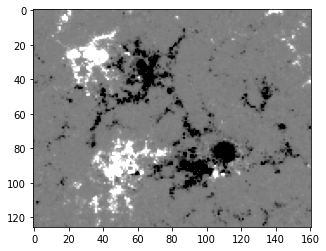

5


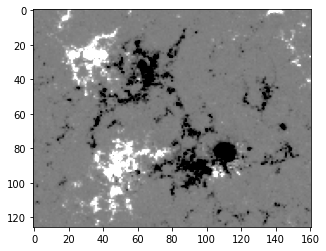

6


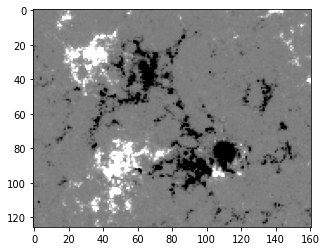

7


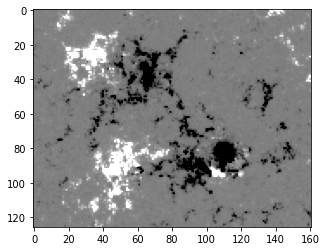

8


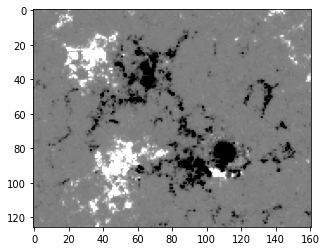

9


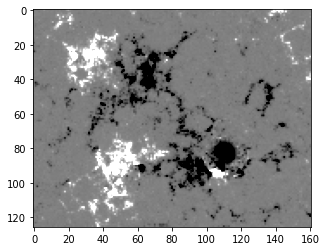

10


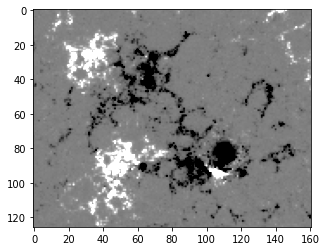

11


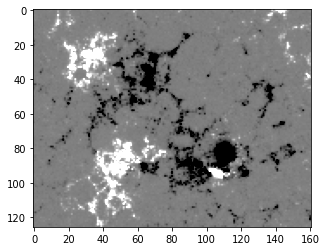

12


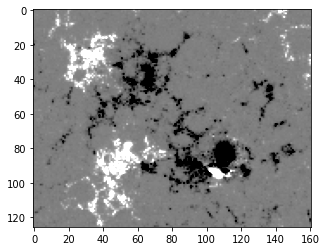

13


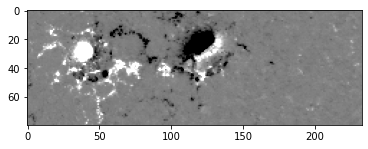

14


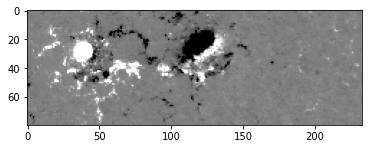

15


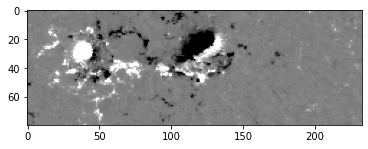

16


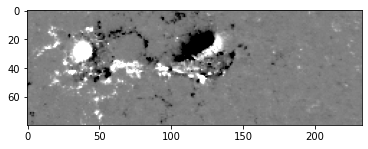

In [39]:
for i, batch in enumerate(dl_pos.dataset):
    print(i)
    plt.imshow(batch[0][0,0], cmap='gray', vmin=-200, vmax=200)
    ensemble_pred = df_pos.iloc[i]['Ensemble prob'] > 0.5
    plt.savefig(output_dir / 'pos_{}_{}'.format(ensemble_pred, i))
    plt.show()

0


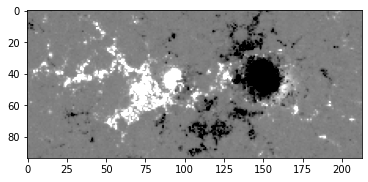

1


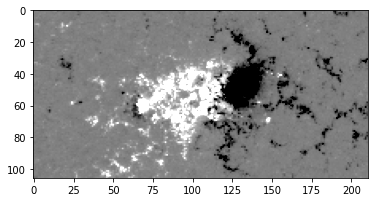

2


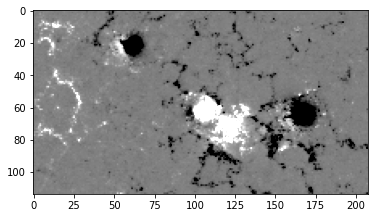

3


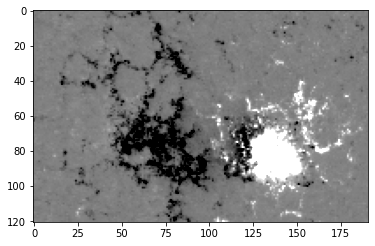

In [40]:
for i, batch in enumerate(dl_neg.dataset):
    print(i)
    plt.imshow(batch[0][0,0], cmap='gray', vmin=-200, vmax=200)
    ensemble_pred = df_neg.iloc[i]['Ensemble prob'] < 0.5
    plt.savefig(output_dir / 'neg_{}_{}'.format(ensemble_pred, i))
    plt.show()

## Train ensemble weights on validation set

In [23]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
#meta_learner = SVC(kernel='linear')
meta_learner = LogisticRegression()
meta_learner.fit(df_val[['LSTM prob', 'CNN prob']], df_val['label'])

LogisticRegression()

In [24]:
meta_learner.coef_, meta_learner.intercept_

(array([[6.14258424, 2.65448051]]), array([-4.26736316]))

## Cross-validation

In [26]:
## The working directory should be in the branch of leaderboard3
dfs = {estimator: predict_cv('sharp', 0, estimator)
       for estimator in ['CNN', 'LSTM']}

NameError: name 'predict_cv' is not defined

given dataset, seed, estimator
dfs['CNN'], dfs['LSMT']
but all we need is split.
df_train, with CNN and LSTM prediction
df_val
df_test


construct cv_datamodule that returns loaders as

In [ ]:
def get_split(split):
    df_fig = dfs['LSTM'][split].copy()
    df_fig = df_fig.rename(columns={'prob': 'LSTM prob'})
    df_fig['label'] = df_fig['label'].astype(bool)
    df_fig['CNN prob'] = dfs['CNN'][split]['prob']
    return df_fig

In [ ]:
df_train = get_split('train')
df_val = get_split('val')
df_test = get_split('test')